# Figure
This figure is about predicting a fixed forecasting horizon using different averaging and showcasing the errors. We can see that The averaging is not going to influece the acuracy of predictions that much. 

Importing the required packages. Make sure to have the virtual environment set-up and active

In [13]:
import pandas as pd 
import numpy as np
from darts import TimeSeries
from darts.metrics import mape, mae, ope, mase
from sklearn.linear_model import BayesianRidge

from darts.dataprocessing.transformers import Scaler
import joblib, pickle, subprocess

from datetime import datetime
import os


from aeml.utils.Plot import *
from aeml.utils.metrics import AE


Loading the original data and average using different number of points in order to construct a list of actual measurements with different number of averaged points

In [14]:
df = pd.read_pickle('/home/lsmo/Desktop/aeml_project/aeml/DataDynamo/RawData/New_campaigns/202403 SCOPE data set dynamic campaign.pkl')

df = df.dropna()

TARGETS_clean = ['AMP-4', 'PZ-4'] 

# =============================================================================
# Convert to TimeSeries and scale the data
y = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean, time_col='Date')


y_transformer = Scaler()
y = y_transformer.fit_transform(y)

# Calculate the average of the time series
average = np.mean(y_transformer.inverse_transform(y)[TARGETS_clean[0]].values())

def average_timeseries(df, skip):
    return df.rolling(window=skip, min_periods=1).mean()[::skip]

# Convert TimeSeries to DataFrame for processing
df_y = y.pd_dataframe()

# Apply averaging function
temp_y = average_timeseries(df_y, 24)
temp_y.columns = y.pd_dataframe().columns
y = TimeSeries.from_dataframe(temp_y)


#* Inverse Transforming the series
y_actual_24 = y_transformer.inverse_transform(y)

# Apply averaging function
temp_y = average_timeseries(df_y, 30)
temp_y.columns = y.pd_dataframe().columns
y = TimeSeries.from_dataframe(temp_y)


#* Inverse Transforming the series
y_actual_30 = y_transformer.inverse_transform(y)


# Apply averaging function
temp_y = average_timeseries(df_y, 36)
temp_y.columns = y.pd_dataframe().columns
y = TimeSeries.from_dataframe(temp_y)


#* Inverse Transforming the series
y_actual_36 = y_transformer.inverse_transform(y)


# Apply averaging function
temp_y = average_timeseries(df_y, 42)
temp_y.columns = y.pd_dataframe().columns
y = TimeSeries.from_dataframe(temp_y)


#* Inverse Transforming the series
y_actual_42 = y_transformer.inverse_transform(y)


# Apply averaging function
temp_y = average_timeseries(df_y, 48)
temp_y.columns = y.pd_dataframe().columns
y = TimeSeries.from_dataframe(temp_y)


#* Inverse Transforming the series
y_actual_48 = y_transformer.inverse_transform(y)

# Apply averaging function
temp_y = average_timeseries(df_y, 96)
temp_y.columns = y.pd_dataframe().columns
y = TimeSeries.from_dataframe(temp_y)


#* Inverse Transforming the series
y_actual_96 = y_transformer.inverse_transform(y)


Loading the historical forecast .pkl files. The files that contain "FullForecast" in their name are the median percentile. We only use this for calculating the absolute error

In [15]:
# =============================================================================
# Pickle names and paths
commit_id = '81991c4'
date_string = '22042024_183525'
Model='Tiny_Model'
output_path = os.getcwd() + f'/Output/{Model}/'
skip = 24

# =============================================================================
# Reading the historical forecast outputs generated by ModelTrain_Choronos.py
# Read the lists from the files
with open(output_path + f'{commit_id}_FullForecast_{date_string}_Skip{skip}.pkl', 'rb') as f:
    FullForecast_df = pickle.load(f)

FullForecast24 = [TimeSeries.from_dataframe(df) for df in FullForecast_df]

# =============================================================================
# Pickle names and paths
commit_id = '06c2271'
date_string = '25062024_182503'
skip = 30

# =============================================================================
# Reading the historical forecast outputs generated by ModelTrain_Choronos.py
# Read the lists from the files
with open(output_path + f'{commit_id}_FullForecast_{date_string}_Skip{skip}.pkl', 'rb') as f:
    FullForecast_df = pickle.load(f)

FullForecast30 = [TimeSeries.from_dataframe(df) for df in FullForecast_df]

# =============================================================================
# Pickle names and paths
commit_id = '06c2271'
date_string = '25062024_184536'
skip = 36

# =============================================================================
# Reading the historical forecast outputs generated by ModelTrain_Choronos.py
# Read the lists from the files
with open(output_path + f'{commit_id}_FullForecast_{date_string}_Skip{skip}.pkl', 'rb') as f:
    FullForecast_df = pickle.load(f)

FullForecast36 = [TimeSeries.from_dataframe(df) for df in FullForecast_df]

# =============================================================================
# Pickle names and paths
commit_id = '06c2271'
date_string = '25062024_190252'
skip = 42

# =============================================================================
# Reading the historical forecast outputs generated by ModelTrain_Choronos.py
# Read the lists from the files
with open(output_path + f'{commit_id}_FullForecast_{date_string}_Skip{skip}.pkl', 'rb') as f:
    FullForecast_df = pickle.load(f)

FullForecast42 = [TimeSeries.from_dataframe(df) for df in FullForecast_df]


# =============================================================================
# Pickle names and paths
commit_id = 'c7071ee'
date_string = '08042024_041232'
skip = 48

# =============================================================================
# Reading the historical forecast outputs generated by ModelTrain_Choronos.py
# Read the lists from the files
with open(output_path + f'{commit_id}_FullForecast_{date_string}_Skip{skip}.pkl', 'rb') as f:
    FullForecast_df = pickle.load(f)

FullForecast48 = [TimeSeries.from_dataframe(df) for df in FullForecast_df]

# =============================================================================
# Pickle names and paths
commit_id = 'c7071ee'
date_string = '08042024_141139'
skip = 96

# =============================================================================
# Reading the historical forecast outputs generated by ModelTrain_Choronos.py
# Read the lists from the files
with open(output_path + f'{commit_id}_FullForecast_{date_string}_Skip{skip}.pkl', 'rb') as f:
    FullForecast_df = pickle.load(f)

FullForecast96 = [TimeSeries.from_dataframe(df) for df in FullForecast_df]


Selecting the last point of the 24 points averaging

In [16]:
# =============================================================================
# Extract the prediction point from the historical forecast
# Which prediction point in histoical forecast to get and plot. from 0 to len(FullForecast[0]) - 1
prediction_point = len(FullForecast24[0]) - 1
prediction_time = (prediction_point + 1) * 24 * 10 / 60 # In minutes
print(prediction_point)

# Extract the point of each time series
point_selected_values = [ts.values()[prediction_point] for ts in FullForecast24]
point_selected_times = [ts.time_index[prediction_point] for ts in FullForecast24]

# Create a new time series from the points
point_selected_ts = TimeSeries.from_times_and_values(pd.DatetimeIndex(point_selected_times), point_selected_values)


point_selected_df = point_selected_ts.pd_dataframe()
point_selected_df.columns = [TARGETS_clean[0]]
point_selected_df.index.name = 'Date'

y_forecast_24 = TimeSeries.from_dataframe(point_selected_df)


63


Selecting the same forecasting horizon as the 24 points averaging in 30 to 96 averaging

In [17]:
# =============================================================================
# Extract the prediction point from the historical forecast
# Which prediction point in histoical forecast to get and plot. from 0 to len(FullForecast[0]) - 1
prediction_point = int((len(FullForecast30[0]) - 1 ) // (30/24))
prediction_time = (prediction_point + 1) * 30 * 10 / 60 # In minutes

# Extract the point of each time series
point_selected_values = [ts.values()[prediction_point] for ts in FullForecast30]
point_selected_times = [ts.time_index[prediction_point] for ts in FullForecast30]

# Create a new time series from the points
point_selected_ts = TimeSeries.from_times_and_values(pd.DatetimeIndex(point_selected_times), point_selected_values)

point_selected_df = point_selected_ts.pd_dataframe()
point_selected_df.columns = [TARGETS_clean[0]]
point_selected_df.index.name = 'Date'

y_forecast_30 = TimeSeries.from_dataframe(point_selected_df)

In [18]:
# =============================================================================
# Extract the prediction point from the historical forecast
# Which prediction point in histoical forecast to get and plot. from 0 to len(FullForecast[0]) - 1
prediction_point = int((len(FullForecast36[0]) - 1 ) // (36/24))
prediction_time = (prediction_point + 1) * 36 * 10 / 60 # In minutes

# Extract the point of each time series
point_selected_values = [ts.values()[prediction_point] for ts in FullForecast36]
point_selected_times = [ts.time_index[prediction_point] for ts in FullForecast36]

# Create a new time series from the points
point_selected_ts = TimeSeries.from_times_and_values(pd.DatetimeIndex(point_selected_times), point_selected_values)

point_selected_df = point_selected_ts.pd_dataframe()
point_selected_df.columns = [TARGETS_clean[0]]
point_selected_df.index.name = 'Date'

y_forecast_36 = TimeSeries.from_dataframe(point_selected_df)

In [19]:
# =============================================================================
# Extract the prediction point from the historical forecast
# Which prediction point in histoical forecast to get and plot. from 0 to len(FullForecast[0]) - 1
prediction_point = int((len(FullForecast42[0]) - 1 ) // (42/24))
prediction_time = (prediction_point + 1) * 42 * 10 / 60 # In minutes

# Extract the point of each time series
point_selected_values = [ts.values()[prediction_point] for ts in FullForecast42]
point_selected_times = [ts.time_index[prediction_point] for ts in FullForecast42]

# Create a new time series from the points
point_selected_ts = TimeSeries.from_times_and_values(pd.DatetimeIndex(point_selected_times), point_selected_values)

point_selected_df = point_selected_ts.pd_dataframe()
point_selected_df.columns = [TARGETS_clean[0]]
point_selected_df.index.name = 'Date'

y_forecast_42 = TimeSeries.from_dataframe(point_selected_df)

In [20]:
# =============================================================================
# Extract the prediction point from the historical forecast
# Which prediction point in histoical forecast to get and plot. from 0 to len(FullForecast[0]) - 1
prediction_point = int((len(FullForecast48[0]) - 1 ) // (48/24))
prediction_time = (prediction_point + 1) * 48 * 10 / 60 # In minutes

# Extract the point of each time series
point_selected_values = [ts.values()[prediction_point] for ts in FullForecast48]
point_selected_times = [ts.time_index[prediction_point] for ts in FullForecast48]

# Create a new time series from the points
point_selected_ts = TimeSeries.from_times_and_values(pd.DatetimeIndex(point_selected_times), point_selected_values)

point_selected_df = point_selected_ts.pd_dataframe()
point_selected_df.columns = [TARGETS_clean[0]]
point_selected_df.index.name = 'Date'

y_forecast_48 = TimeSeries.from_dataframe(point_selected_df)

In [21]:
# =============================================================================
# Extract the prediction point from the historical forecast
# Which prediction point in histoical forecast to get and plot. from 0 to len(FullForecast[0]) - 1
prediction_point = int((len(FullForecast96[0]) - 1 ) // (96/24))
prediction_time = (prediction_point + 1) * 96 * 10 / 60 # In minutes

# Extract the point of each time series
point_selected_values = [ts.values()[prediction_point] for ts in FullForecast96]
point_selected_times = [ts.time_index[prediction_point] for ts in FullForecast96]

# Create a new time series from the points
point_selected_ts = TimeSeries.from_times_and_values(pd.DatetimeIndex(point_selected_times), point_selected_values)

point_selected_df = point_selected_ts.pd_dataframe()
point_selected_df.columns = [TARGETS_clean[0]]
point_selected_df.index.name = 'Date'

y_forecast_96 = TimeSeries.from_dataframe(point_selected_df)

Constructing the AE error bars. you should pass a list of TimeSeries to the make_ae_error_plot. See Plot.py script in Utils for more information

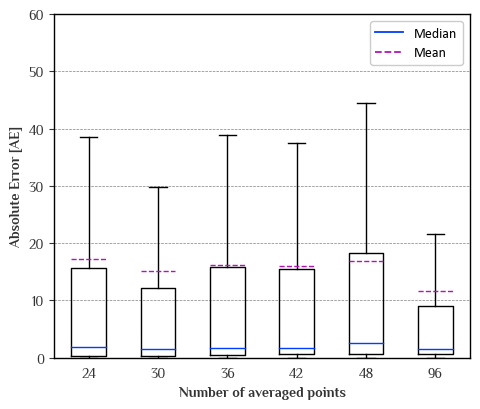

In [23]:

y_forecast_list = [y_forecast_24, y_forecast_30, y_forecast_36, y_forecast_42, y_forecast_48, y_forecast_96]

y_actual_list = [y_actual_24[TARGETS_clean[0]][:int(92241/24)],
                    y_actual_30[TARGETS_clean[0]][:int(92241/30)],
                    y_actual_36[TARGETS_clean[0]][:int(92241/36)], 
                    y_actual_42[TARGETS_clean[0]][:int(92241/42)], 
                    y_actual_48[TARGETS_clean[0]][:int(92241/48)], 
                    y_actual_96[TARGETS_clean[0]][:int(92241/96)]]

time_horizon = ['24', '30', '36', '42', '48', '96']
make_ae_error_plot(y_actual_list, 
                    y_forecast_list,
                    time_horizon,
                    Violin=False,
                    Box=True,
                    y_lim=(0, 60),
                    x_label='Number of averaged points',
                    output_Name='Different_Averaging_Error'
                    )
